In [17]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from price_impact.modelling.backtest_analysis import BacktestResults, BacktestSettings 
from price_impact.modelling.Futures import  Spot, FutureContract

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

import seaborn as sns
from model_calibration_tools import intraday_analysis_plot, SAMPLE_SPOTS, plot_delta_changes, lambda_heatplots

from typing import List, Tuple, Dict
PLOT_FOLDER = Path("./plots")
plt.style.use('bmh')

### Intraday Analysis

ES
NQ
CL
GL
TU
GC


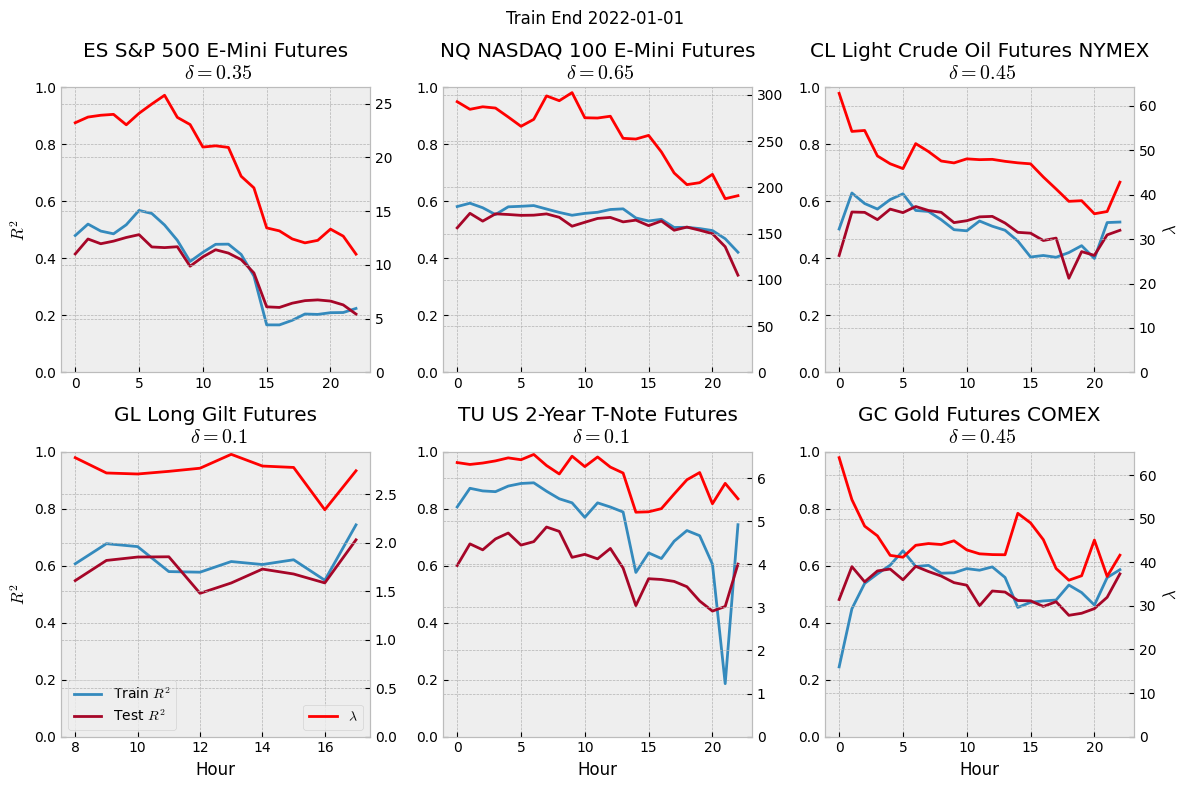

In [18]:
backtest_settings = BacktestSettings(
    train_len=6,
    test_len=3,
    bin_freq='10s',
    forecast_horizon_s=10,
    smoothing_str='sma20',
    decay=3600
)


fig, axs = plt.subplots(2, 3, figsize=(12, 8))
date = '2022-01-01'

for idx, spot in enumerate(SAMPLE_SPOTS):
    print(spot)
    spot = Spot(spot)
    backtest_results = BacktestResults(spot, backtest_settings)
    i, j = idx//3, idx % 3
    ax = axs[i][j]

    legend = idx == 3

    ax, ax2 = intraday_analysis_plot(ax, backtest_results, date=date,
                                     legend=legend)

    if i == 1:
        ax.set_xlabel("Hour")
    else:
        ax.set_xlabel(None)
    if j == 0:
        ax.set_ylabel("$R^2$")

    elif j == 2:
        ax2.set_ylabel("$\lambda$")


fig.suptitle(f"Train End {date}")
fig.tight_layout()
fig.savefig(PLOT_FOLDER/'model_calibration'/f'intraday_analysis_{backtest_settings.train_len}_{backtest_settings.test_len}.png')

In [19]:
spot = 'ES'
train_len, test_len = 6,3
test_start, impact = '2022-01-01', 0.1

backtest_results = BacktestResults(spot,backtest_settings)
df  = backtest_results.results_df.query(f"test_start=='{test_start}' and impact == {impact}")
df.loc[:, ['impact','value']] = df[['impact','value']].applymap(lambda x: f"{x:.2f}")
df = df[['hour','variable','value']].sort_values(by=['variable', 'hour'])

df = df.pivot(index='hour', columns='variable',values='value').reset_index()

df.columns = ['Hour', '$\lambda$',  'Test $R^2$',  'Train $R^2$']
df.to_latex(f'./tables/model_calibration/initial_r2_{train_len}_{test_len}.tex', index=False, escape=False)

c:\ProgramData\Anaconda3\envs\jh39\lib\site-packages\pandas\core\indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


### Heat plots  of lambda 

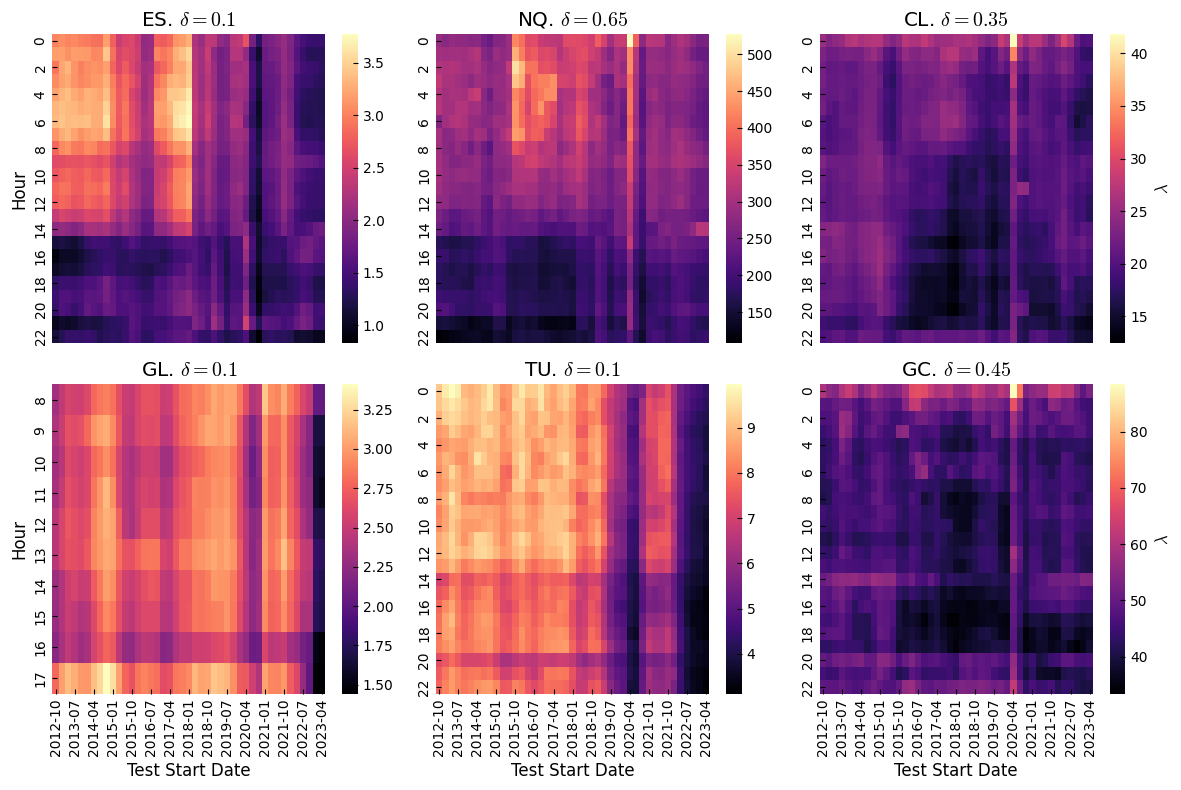

In [20]:

train_len, test_len = 6, 3
fig, axs = lambda_heatplots(delta=None, backtest_settings= backtest_settings)
fig.savefig(PLOT_FOLDER/'model_calibration'/f'lambda_heatplots_{train_len}_{test_len}.png')

### Delta changes over time

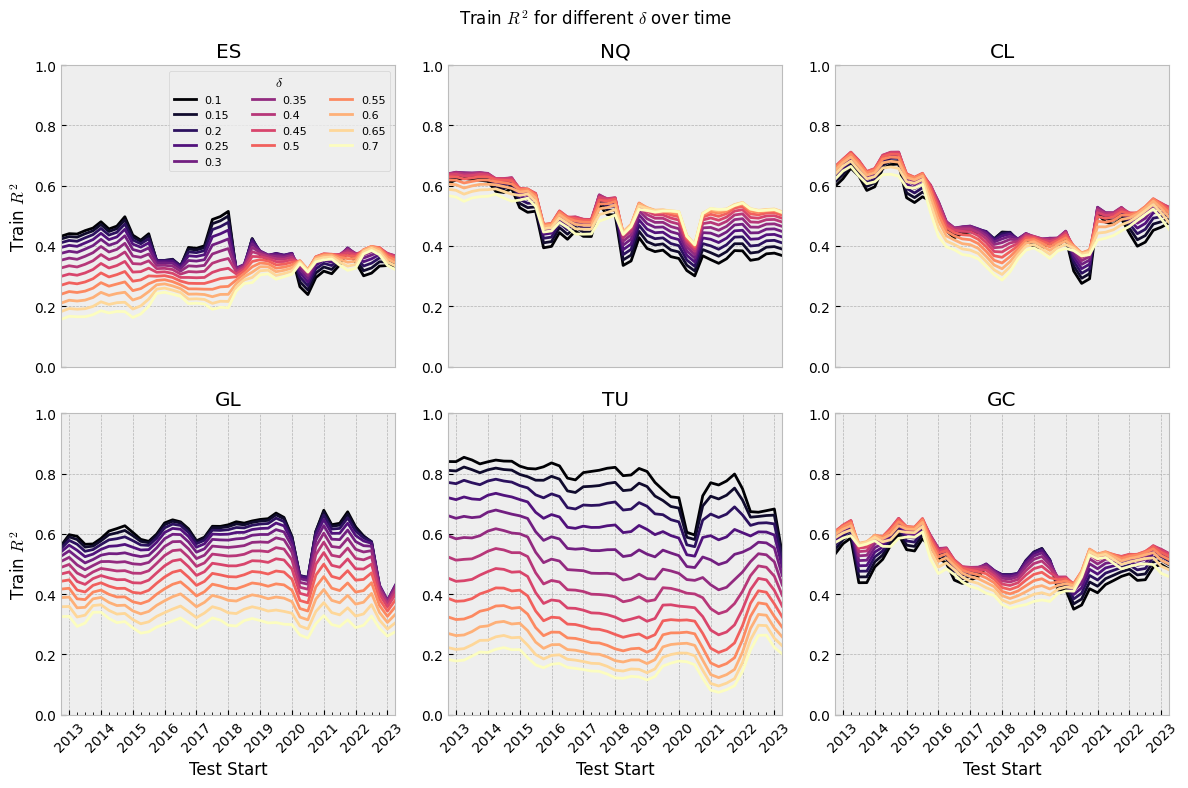

In [21]:
train_len, test_len = 6, 3

fig, ax = plot_delta_changes(backtest_settings=backtest_settings)
fig.tight_layout()
fig.savefig(PLOT_FOLDER/'model_calibration'/f'train_r2_over_time_{train_len}_{test_len}.png')

### Regret metrics for model selection

train_len=6, test_len=3


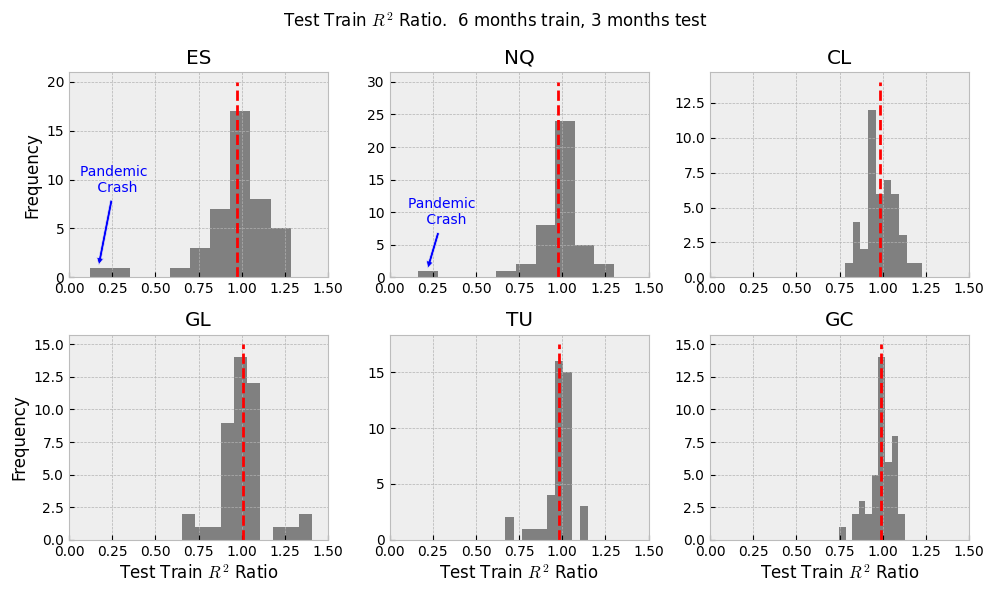

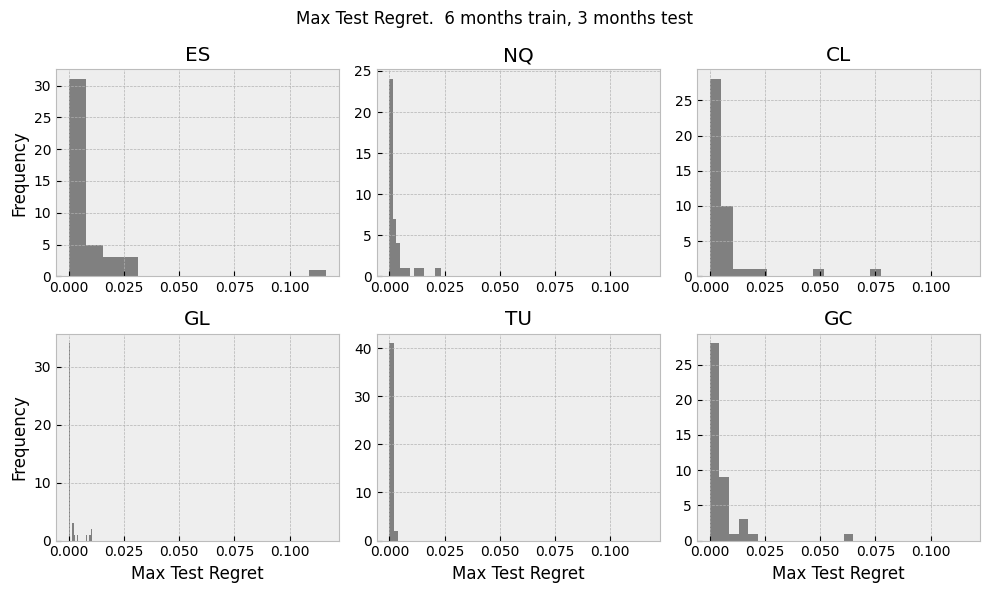

In [22]:
from price_impact import tickers as spots
train_len, test_len = 6, 3

print(f"{train_len=}, {test_len=}")

fig1, axs1 = plt.subplots(2, 3, figsize=(10, 6))
fig2, axs2 = plt.subplots(2, 3, figsize=(10, 6))
for idx, spot in enumerate(SAMPLE_SPOTS):
    backtest_results = BacktestResults(spot, backtest_settings)

    gb = backtest_results.r2_df_average
    results_dict = {}

    # pick 'best parameter' from the train results

    best_train_params = backtest_results.get_best_impact_coefs('train')
    best_test_params = backtest_results.get_best_impact_coefs('test')

    # compare train best params with test params
    best_train_params = pd.merge(left=gb.melt(ignore_index=False).reset_index(),
                                 right=best_train_params,
                                 how='inner',
                                 left_on=['test_start', 'impact'],
                                 right_on=['test_start', 'impact'])

    best_test_params = pd.merge(left=gb.melt(ignore_index=False).reset_index(),
                                right=best_test_params,
                                how='inner',
                                left_on=['test_start', 'impact'],
                                right_on=['test_start', 'impact'])

    best_tr_impacts = best_train_params.pivot(
        index=['test_start', 'impact'],
        columns='variable', values='value').reset_index().sort_values(
        by=['test_start']).reset_index(
        drop=True)

    best_te_impacts = best_test_params.pivot(
        index=['test_start', 'impact'],
        columns='variable', values='value').reset_index().sort_values(
        by=['test_start']).reset_index(
        drop=True)

    b_tr_b_te = pd.merge(best_tr_impacts, best_te_impacts, on=['test_start'],
                         suffixes=('_tr', '_te')).sort_values(by='test_start')

    i, j = idx//3, idx % 3

    ax = axs1[i][j]
    b_tr_b_te['tt_ratio'] = b_tr_b_te['test_r2_tr'] / b_tr_b_te['train_r2_tr']
    ax = b_tr_b_te['tt_ratio'].plot(ax=ax, kind='hist', color='grey')

    ax.set_title(spot)
    ax.set_xlim(left=0, right=1.5)

    if spot in ['ES', 'NQ']:

        covid_rrt = b_tr_b_te.query("test_start=='2020-04-01'")['tt_ratio'].min() + 0.05
        ax.annotate("Pandemic \n Crash",
                    xy=(covid_rrt, 1), xycoords='data',
                    xytext=(covid_rrt+0.1, 10), textcoords='data',
                    size=10, va="center", ha="center",
                    color='b',
                    arrowprops=dict(arrowstyle="simple",
                                    fc="b"),
                    )

    ax.vlines(b_tr_b_te['tt_ratio'].mean(), ymin=ax.get_yticks().min(),
              ymax=ax.get_yticks().max(), color='r', linestyle='--')

    ax = axs2[i][j]
    bins = 2 if spot == 'TU' else 15
    b_tr_b_te['regret'] = b_tr_b_te['test_r2_te'] - b_tr_b_te['test_r2_tr']
    ax = b_tr_b_te['regret'].plot(ax=ax, kind='hist', bins=bins, color='grey')
    ax.set_title(spot)

    if j:
        axs2[i][j].set_ylabel(None)
        axs1[i][j].set_ylabel(None)
    if i:
        axs1[i][j].set_xlabel(r"Test Train $R^2$ Ratio")
        axs2[i][j].set_xlabel(r"Max Test Regret")


min_z = 1e9
max_z = -1e9

for idx in range(6):
    i, j = idx//3, idx % 3
    mi, ma = axs2[i][j].get_xlim()
    min_z = min(min_z, mi)
    max_z = max(max_z, ma)

for idx in range(6):
    i, j = idx//3, idx % 3
    axs2[i][j].set_xlim(min_z, max_z)


fig1.suptitle(fr'Test Train $R^2$ Ratio.  {train_len} months train, {test_len} months test')
fig1.tight_layout()
fig1.savefig(PLOT_FOLDER/'model_calibration'/f'test_train_ratio_{train_len}_{test_len}.png')

fig2.suptitle(f'Max Test Regret.  {train_len} months train, {test_len} months test')
fig2.tight_layout()
fig2.savefig(PLOT_FOLDER/'model_calibration'/f'max_test_regret_{train_len}_{test_len}.png')

### Lambda compare with constant delta


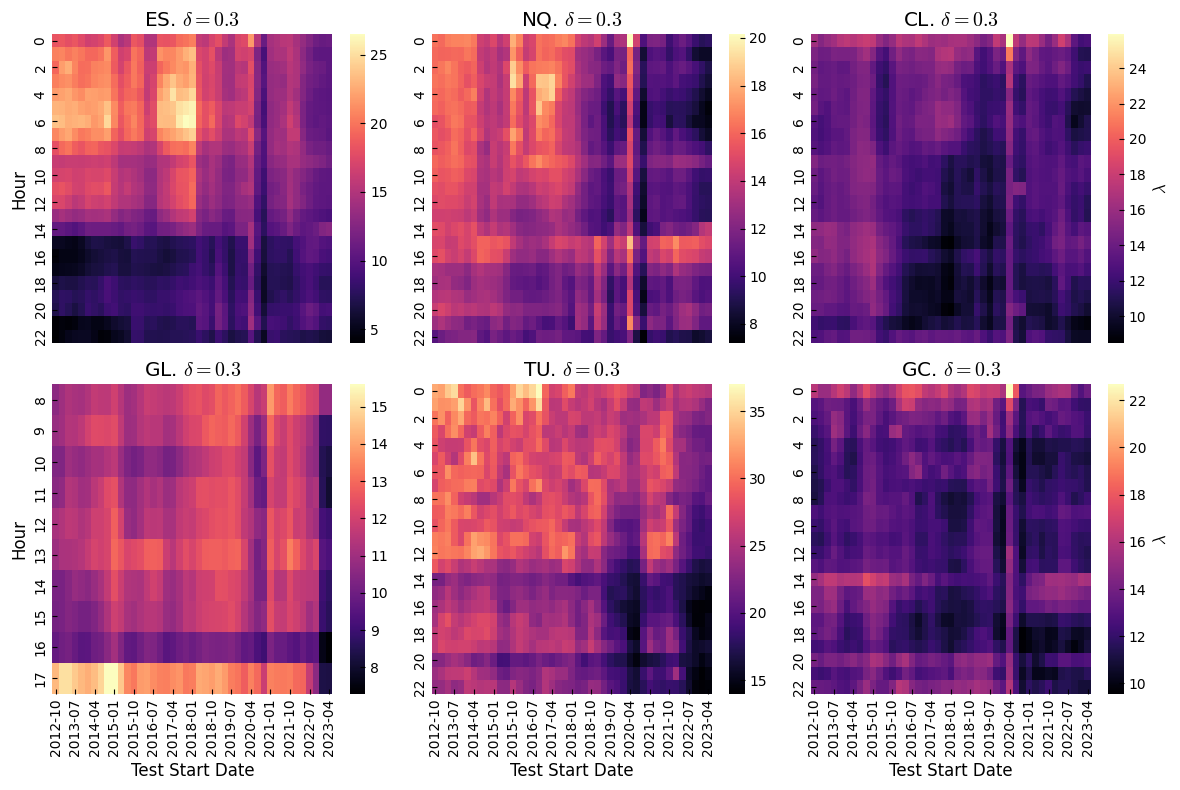

In [23]:
backtest_settings = BacktestSettings(
    train_len=6,
    test_len=3,
    bin_freq='10s',
    forecast_horizon_s=10,
    smoothing_str='sma20',
    decay=3600
)
fig, axs = lambda_heatplots(delta=0.3, backtest_settings=backtest_settings)

fig.savefig(PLOT_FOLDER/'model_calibration'/f'lambda_heatplots_const_delta_{train_len}_{test_len}.png')

### improvements by train_test len

In [24]:
from concurrent.futures import ThreadPoolExecutor

spots = list(set(map(lambda x: x.split('-')[0], os.listdir(results_path/'model_output'))))

df_list =  []
results_list = []

def get_stat_dict(spot, train_len, test_len, smoothing='sma20'):
    backtest_settings = BacktestSettings(
    train_len=train_len,
    test_len=test_len,
    bin_freq='10s',
    forecast_horizon_s=10,
    smoothing_str=smoothing,
    decay=3600
    )

    backtest_results = BacktestResults(spot, backtest_settings)
    stat_dict = backtest_results.statistics_dict
    stat_dict['spot'] = spot
    return stat_dict
    
with ThreadPoolExecutor(60) as executor:
    for train_len, test_len in [(6,3),(4,2),(2,1), (1,1)]:
        # print(train_len, test_len)
        results_list = executor.map(lambda x: get_stat_dict(x, train_len, test_len), spots)
        
        df = pd.DataFrame(results_list)
        df['train_len'] = train_len
        df['test_len'] = test_len
        df_list.append(df)
    

df = pd.concat(df_list)

In [25]:
summary = df.groupby(by=['train_len','test_len'])[['avg_tr_fr_tr','avg_te_fr_tr','avg_tr_fr_te','avg_te_fr_te','test_train_ratio','avg_max_test_regret']].mean()
summary['test_train_ratio'] = summary['avg_te_fr_tr']/summary['avg_tr_fr_tr']
summary = summary[['avg_tr_fr_tr','avg_te_fr_tr','test_train_ratio','avg_max_test_regret']].sort_values(by='avg_te_fr_tr', ascending=False).reset_index()

In [26]:
summary.columns = ['Train months','Test months', r'Avg Train $R^2$',r'Avg Test $R^2$', 'Test Train Ratio', 'Test Regret']
summary.to_latex(f'./tables/model_calibration/tt_compare.tex', index=False, float_format="%.4f", escape=False)

In [27]:
from typing import List, Tuple

intrest_rates = pd.read_excel(f"./data/interest_rates.xlsx")
intrest_rates = intrest_rates.iloc[1:,:]
intrest_rates = intrest_rates.rename(columns={'Unnamed: 0':'Date'})
intrest_rates.set_index(intrest_rates.columns[0], inplace=True)
intrest_rates.sort_index(inplace=True)
intrest_rates = intrest_rates.fillna(method='ffill').fillna(method='bfill')

In [28]:
train_len, test_len = 1,1
backtest_settings = BacktestSettings(
    train_len=train_len,
    test_len=test_len,
    bin_freq='10s',
    forecast_horizon_s=10,
    smoothing_str='sma20',
    decay=3600
    )
def plot_ir_analysis(tick_bbg: List[Tuple]):
    fig, axs = plt.subplots(1,len(tick_bbg), figsize=(4*len(tick_bbg),6))
    
    if isinstance(axs, plt.Axes):
        axs = [axs]
        
    for idx, (tick_spot, bbg_ticker) in enumerate(tick_bbg):
        backtest_results = BacktestResults(tick_spot, backtest_settings)
        avg_lambdas = backtest_results.results_df.query(f"impact==0.1 and variable=='coef'").groupby('test_start')['value'].mean()
        avg_lambdas.index=pd.to_datetime(avg_lambdas.index, format= '%Y-%m-%d')

        ir_plot_df = intrest_rates[intrest_rates.index>= min(avg_lambdas.index)]
        ax = axs[idx]
        axs[idx] = avg_lambdas.plot(label=tick_spot, ax=axs[idx])
        ax = ir_plot_df[bbg_ticker].plot(ax=ax, label=bbg_ticker)
        ax.legend()
        
        ax.set_title(Spot(tick_spot).description)

    _max = 0    
    for idx in range(len(tick_bbg)):
        _max = max(_max, axs[idx].get_ylim()[1])

        
    for idx in range(len(tick_bbg)):
        axs[idx].set_ylim(bottom=0, top=_max)
        
    axs[0].set_ylabel(r'$ \lambda $ and % interest rate')
    
    return fig, axs


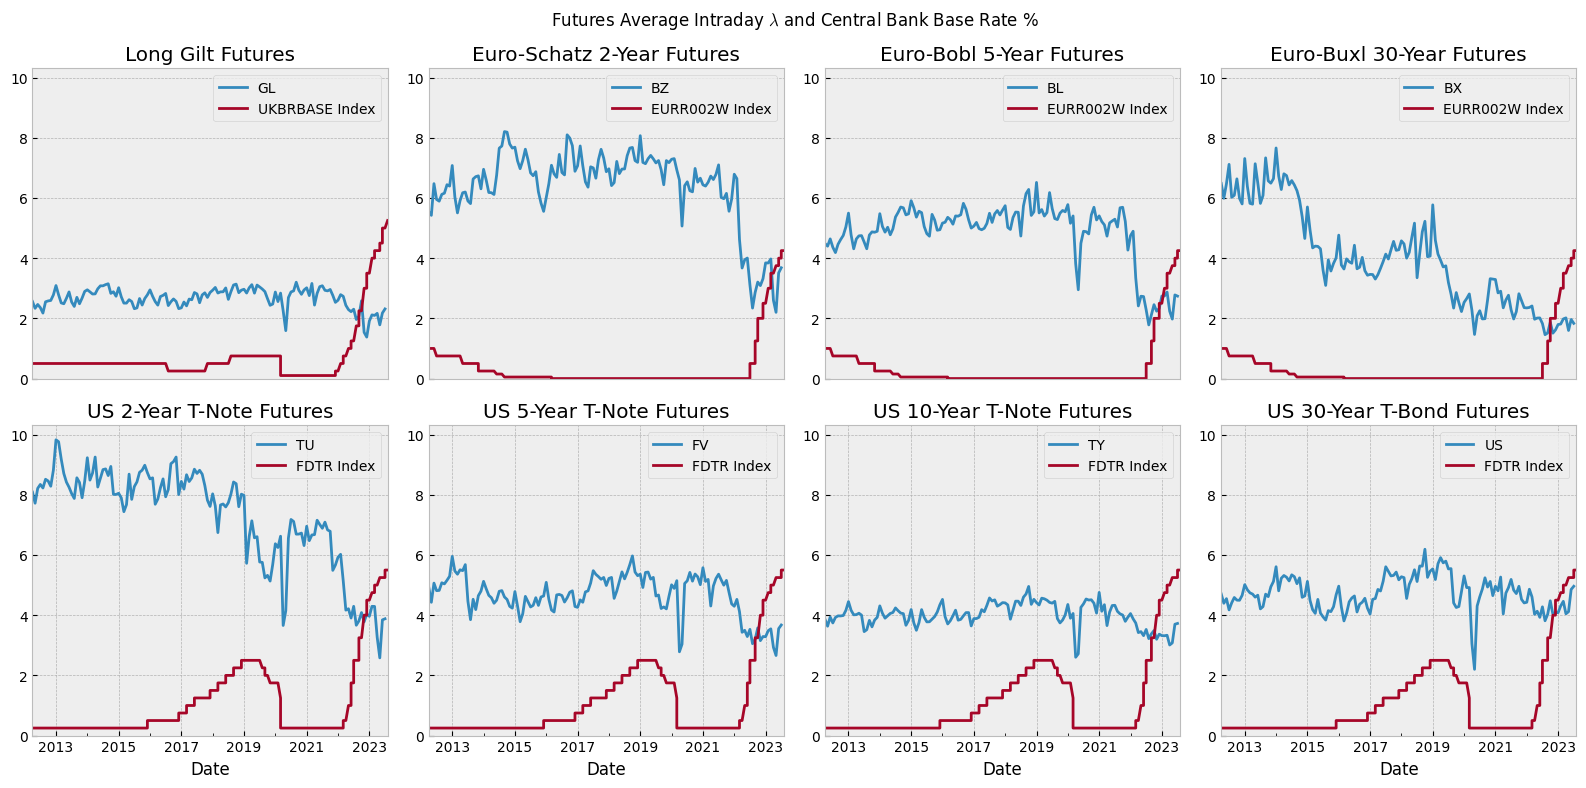

In [29]:
uk = [('GL', 'UKBRBASE Index')]
euro = [('BZ','EURR002W Index'),('BL','EURR002W Index'),('BX','EURR002W Index')]
us = [('TU' ,'FDTR Index'), ('FV' ,'FDTR Index'), ('TY' ,'FDTR Index'), ('US' ,'FDTR Index')]
aus = [('AY','RBATCTR Index'),('AX','RBATCTR Index')]

fig, axs=plt.subplots(2,4, figsize=(16,8))

for idx, (tick_spot, bbg_ticker) in enumerate(uk+euro+us):
    i, j = divmod(idx, 4)
    ax = axs[i][j]
    
    backtest_results = BacktestResults(tick_spot,backtest_settings)
    avg_lambdas = backtest_results.results_df.query(f"impact==0.1 and variable=='coef'").groupby('test_start')['value'].mean()
    avg_lambdas.index=pd.to_datetime(avg_lambdas.index, format= '%Y-%m-%d')

    ir_plot_df = intrest_rates[intrest_rates.index>= min(avg_lambdas.index)]
    ax = avg_lambdas.plot(label=tick_spot, ax=ax)
    ax = ir_plot_df[bbg_ticker].plot(ax=ax, label=bbg_ticker)
    ax.legend()
    
    ax.set_title(Spot(tick_spot).description)
    
    if not i:
        ax.set_xlabel(None)
        ax.get_xaxis().set_visible(False)
        
_max = 0    
for idx in range(8):
    i, j = divmod(idx, 4)
    
    _max = max(_max, axs[i][j].get_ylim()[1])

        
for idx in range(8):
    i, j = divmod(idx, 4)
    
    axs[i][j].set_ylim(bottom=0, top=_max)
    
fig.suptitle(r'Futures Average Intraday $\lambda$ and Central Bank Base Rate %')
fig.tight_layout()
fig.savefig(PLOT_FOLDER/'model_calibration'/f'interest_rate_futures.png')


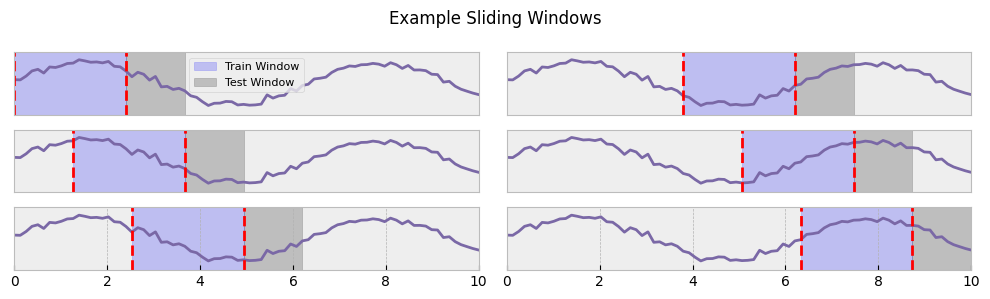

In [30]:
n = 80
np.random.seed(0)
x = np.linspace(0, 10, n)
y = np.sin(x) + np.random.normal(0, 0.1, n)

def sliding_window_cv_demo(x, y, window_size, step_size):
    num_windows = (len(x) - window_size) // step_size 
    num_rows = int(num_windows/2)
    fig, axs = plt.subplots(num_rows, 2, figsize=(10,3))

    for idx in range(num_windows):
        j, i = divmod(idx, num_rows)
        ax = axs[i][j]
        start_idx = idx * step_size
        end_idx = start_idx + window_size

        ax.plot(num_windows, 1, idx+1)
        ax.plot(x, y)
        ax.axvspan(x[start_idx], x[end_idx-1], color='b', alpha=0.2, label='Train Window')
        ax.axvspan(x[end_idx-1], x[end_idx-1+step_size], color='k', alpha=0.2, label='Test Window')
        ax.axvline(x=x[start_idx], color='red', linestyle='--')
        ax.axvline(x=x[end_idx-1], color='red', linestyle='--')
        ax.set_xlim(0, 10)
        ax.set_ylim(-1.5, 1.5)
        
        if idx==0:
            ax.legend(fontsize=8)
        
        if not i == num_rows-1:
            ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle('Example Sliding Windows')
    fig.tight_layout()
    return fig, axs

window_size = 20
step_size = 10
fig, axs = sliding_window_cv_demo(x, y, window_size, step_size)
fig.savefig(PLOT_FOLDER/'model_calibration'/'example_sliding_windows.png')